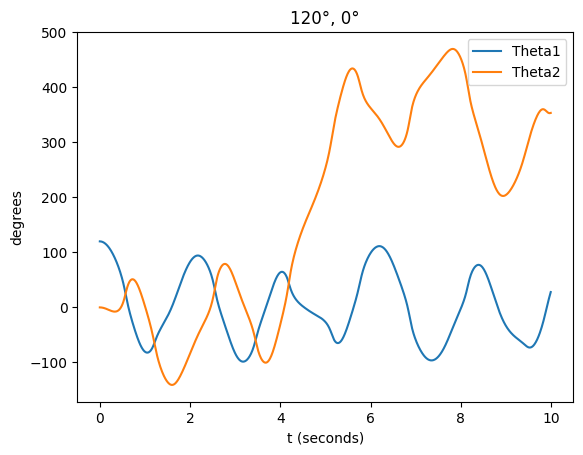

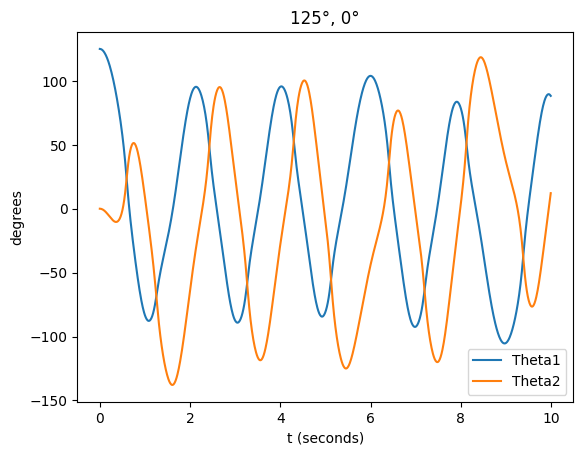

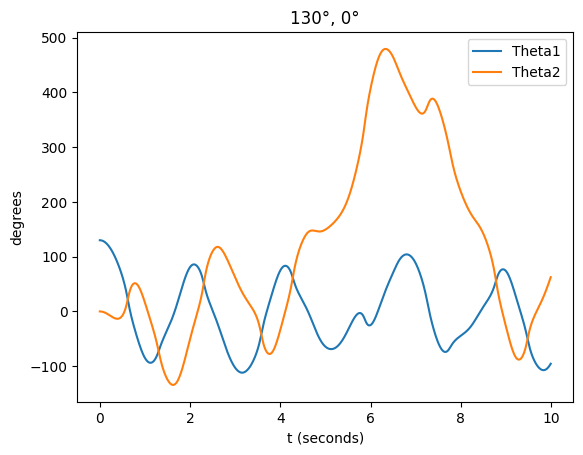

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from math import sin, cos, pi, radians, degrees
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

# Physical constants
g = 9.81  # Acceleration due to gravity (m/s^2)
L1 = 1    # Length of the first pendulum (m)
L2 = 1    # Length of the second pendulum (m)
m1 = 1.0  # Mass of the first pendulum (kg)
m2 = 1.0  # Mass of the second pendulum (kg)

# Derivative function for the double pendulum system
def f(r, t, g, L1, L2, m1, m2):
    theta1, omega1, theta2, omega2 = r
    ftheta1 = omega1
    fomega1 = (
        -g * (2 * m1 + m2) * sin(theta1)
        - m2 * g * sin(theta1 - 2 * theta2)
        - 2 * sin(theta1 - theta2) * m2 * (omega2 ** 2 * L2 + omega1 ** 2 * L1 * cos(theta1 - theta2))
    ) / (L1 * (2 * m1 + m2 - m2 * cos(2 * theta1 - 2 * theta2)))

    ftheta2 = omega2
    fomega2 = (
        2 * sin(theta1 - theta2) * (omega1 ** 2 * L1 * (m1 + m2)
        + g * (m1 + m2) * cos(theta1)
        + omega2 ** 2 * L2 * m2 * cos(theta1 - theta2))
    ) / (L2 * (2 * m1 + m2 - m2 * cos(2 * theta1 - 2 * theta2)))

    return np.array([ftheta1, fomega1, ftheta2, fomega2], float)

# Simulation parameters
a = 0.0   # Start time
b = 100  # End time
N = 10000  # Number of time steps
h = (b - a) / N  # Time step size

# Function to simulate double pendulum motion for given initial angles
def simulate_pendulum(theta1_deg, theta2_deg):
    # Time points
    tpoints = np.arange(a, b, h)

    # Pre-allocate arrays for theta1 and theta2
    theta1_points = np.zeros_like(tpoints)
    theta2_points = np.zeros_like(tpoints)

    # Convert initial conditions to radians for computation
    q = np.array([radians(theta1_deg), 0, radians(theta2_deg), 0], float)

    # Runge-Kutta 4th order method loop
    for i, t in enumerate(tpoints):
        theta1_points[i] = degrees(q[0])  # Store theta1 in degrees
        theta2_points[i] = degrees(q[2])  # Store theta2 in degrees

        k1 = h * f(q, t, g, L1, L2, m1, m2)
        k2 = h * f(q + 0.5 * k1, t + 0.5 * h, g, L1, L2, m1, m2)
        k3 = h * f(q + 0.5 * k2, t + 0.5 * h, g, L1, L2, m1, m2)
        k4 = h * f(q + k3, t + h, g, L1, L2, m1, m2)

        q += (k1 + 2 * k2 + 2 * k3 + k4) / 6

    return tpoints, theta1_points, theta2_points

# Testing a range of initial angles
initial_angles = [[120,0], [125, 0], [130, 0]]
all_data = [] #hold data for all sets of initial angle
all_actual = [] #store data for each initial angle (for later predictions)

for angles in initial_angles:
    tpoints, theta1_points, theta2_points = simulate_pendulum(angles[0], angles[1])

    plt.plot(tpoints[0:1000], theta1_points[0:1000], label=f'Theta1')
    plt.plot(tpoints[0:1000], theta2_points[0:1000], label=f'Theta2')
    plt.title(f'{angles[0]}°, {angles[1]}°')
    plt.xlabel("t (seconds)")
    plt.ylabel("degrees")
    plt.legend()
    plt.show()

    data = np.stack((theta1_points, theta2_points), axis=1)
    all_data.append(data)

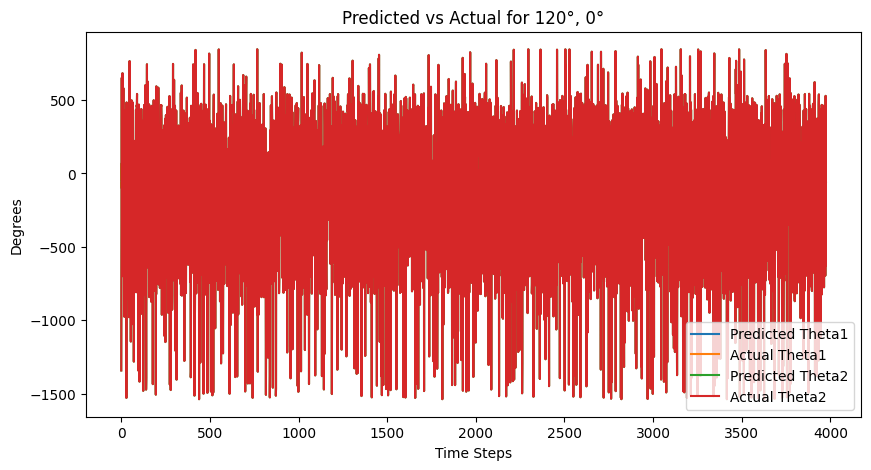

RMSE: 0.0044973627
R^2 Score: 0.9999999980



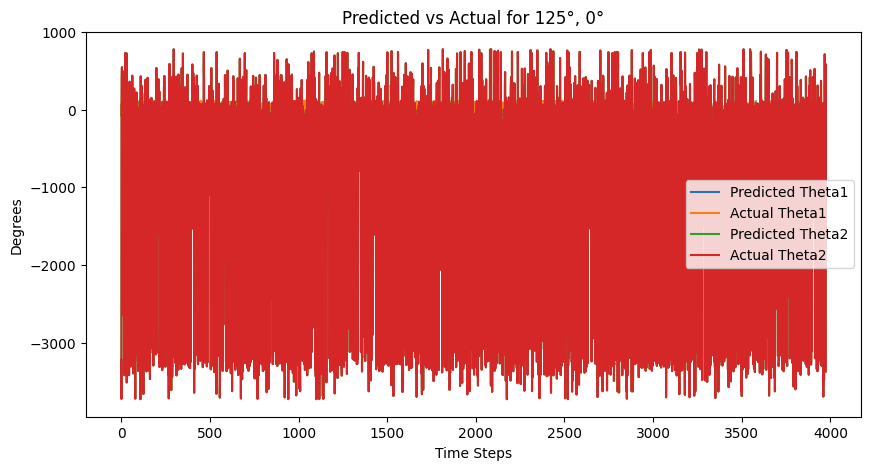

RMSE: 0.0054841725
R^2 Score: 0.9999999972



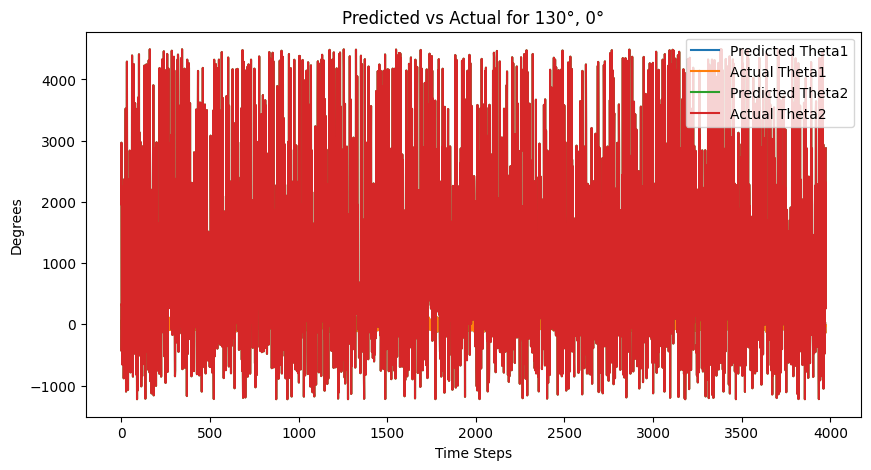

RMSE: 0.0099049428
R^2 Score: 0.9999999909



In [32]:
# Hyperparameters
SEQ_LENGTH = 64
POLY_DEGREE = 2

# Function to create sequences
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i + seq_length]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

for idx, angles in enumerate(initial_angles):
    actual_data = all_data[idx]

    # Create sequences
    X, y = create_sequences(actual_data, SEQ_LENGTH)

    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

    # Normalize
    scaler_X = MinMaxScaler(feature_range=(-1, 1))
    scaler_y = MinMaxScaler(feature_range=(-1, 1))

    # Fit the scalers on the training data
    X_train_scaled = scaler_X.fit_transform(X_train.reshape(-1, 2 * SEQ_LENGTH))
    X_test_scaled = scaler_X.transform(X_test.reshape(-1, 2 * SEQ_LENGTH))
    y_train_scaled = scaler_y.fit_transform(y_train)
    y_test_scaled = scaler_y.transform(y_test)

    # Apply polynomial feature mapping on input data
    poly = PolynomialFeatures(degree=POLY_DEGREE)
    X_train_poly = poly.fit_transform(X_train_scaled)
    X_test_poly = poly.transform(X_test_scaled)

    model = LinearRegression()

    # Fit the model
    model.fit(X_train_poly, y_train_scaled)

    # Predict on the test set
    predictions_scaled = model.predict(X_test_poly)

    # Inverse transform values to return to original scale
    predictions_inverse = scaler_y.inverse_transform(predictions_scaled)
    y_test_inverse = scaler_y.inverse_transform(y_test_scaled)

    # Plot predicted vs actual angles
    plt.figure(figsize=(10, 5))
    plt.plot(predictions_inverse[:, 0], label='Predicted Theta1')
    plt.plot(y_test_inverse[:, 0], label='Actual Theta1')
    plt.plot(predictions_inverse[:, 1], label='Predicted Theta2')
    plt.plot(y_test_inverse[:, 1], label='Actual Theta2')
    plt.title(f'Predicted vs Actual for {angles[0]}°, {angles[1]}°')
    plt.xlabel('Time Steps')
    plt.ylabel('Degrees')
    plt.legend()
    plt.show()

    # Calculate RMSE and R^2 score
    rmse = np.sqrt(mean_squared_error(y_test_inverse, predictions_inverse))
    r2 = r2_score(y_test_inverse, predictions_inverse)

    # Print RMSE and R^2
    print(f'RMSE: {rmse:.10f}')
    print(f'R^2 Score: {r2:.10f}')
    print()